In [3]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import palantir
import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import phate
import plotly.express as px
from anndata import AnnData
import numpy as np
from dash import Dash, dcc, html, Input, Output
scvi.settings.seed = 1995

import pandas as pd
import time

import os
import sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

from copy import copy
reds = copy(mpl.cm.Reds)
reds.set_under("lightgray")

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k * h)[:3]) * 255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

plotly_reds = matplotlib_to_plotly(reds, 255)
plotly_reds[0] = [0.0, 'rgb(211, 211, 211)']
sc.set_figure_params(dpi=50,figsize=[6,4])

# Inline plotting
%matplotlib inline

project_directory = '/Cranio_Lab/Louk_Seton/mesenchyme_project_2023'
os.chdir(os.path.expanduser("~")+project_directory)

Global seed set to 1995


In [4]:
###custom functions
from typing import TYPE_CHECKING, Literal, get_args
_Method = Literal["logreg", "t-test", "wilcoxon", "t-test_overestim_var"]
def plot_deg_embedding(
    adata: AnnData,
    method: _Method,
    groupby: str = 'leiden',
    key_added: str | None = None,
    cluster_name: str = '0',
    n_genes: int = 100,
    basis: str = 'X_scvi_MDE',
) -> AnnData | None:
    avail_methods = set(get_args(_Method))
    if method not in avail_methods:
        raise ValueError(f"Method must be one of {avail_methods}.")
    
    if key_added is None:
        key_added = "rank_genes_groups_"+method
    
    sc.set_figure_params(dpi=50,figsize=[6,4]) #small figures otherwise your notebook will crash
    sc.tl.rank_genes_groups(adata, groupby = groupby, method=method, key_added = key_added)
    genes = adata.uns[key_added]['names'][cluster_name][:n_genes].tolist()
    sc.pl.embedding(adata,
                    basis=basis,
                    color=[groupby]+genes,
                    frameon=False,
                    groups=cluster_name,
                    ncols=4,
                    cmap = reds,
                    vmin=0.1,
                   )

def scvi_anndata_test(
    adata: AnnData,
    batch_key: str = 'batch',
    continuous_covariate_keys: list = ['S_score','G2M_score'],
    layer: str='original_counts',
    n_latent: int = 20,
    n_layers: int = 1,
    max_epochs: int = 500,
    n_neighbors: int = 15,
    resolution: int = 1,
    key_added: str | None = None,
    leiden_key: str = 'leiden_scvi',
) -> AnnData | None:
    if adata.is_view:  # we shouldn't need this here...
        adata._init_as_actual(adata.copy())
    
    if key_added is None:
        latent_key = "X_scvi"
        mde_key = "X_scvi_MDE"
    else:
        latent_key = key_added + "_scvi"
        mde_key = key_added + "_scvi_MDE"
    
    scvi.model.SCVI.setup_anndata(adata, #anndata object
                                  batch_key = batch_key, #categorical key for batch correction
                                  continuous_covariate_keys = continuous_covariate_keys,
                                                                #'total_counts',
                                                                #'pct_counts_mt',
                                                                #continuous key for cell cycle correction
                                  layer = layer) #layer with unmodified counts
    
    adata_model = scvi.model.SCVI(adata,
                                  n_latent = n_latent, #n_latent number of dimensions in latent space (think PCA but different)
                                  n_layers = n_layers, #n_layers number of layers in the neural network
                                 )
    
    print(adata_model.view_anndata_setup(adata))
    
    
    adata_model.train(
        max_epochs = max_epochs, #change how many runs it should train on
    )
    
    adata.obsm[latent_key] = adata_model.get_latent_representation()
    
    sc.pp.neighbors(adata,  #name of anndata object
                    n_neighbors = n_neighbors,
                    use_rep = latent_key,
                   )
    sc.tl.leiden(adata, #name of anndata object
                 resolution = resolution,
                 key_added = leiden_key
                )
    
    adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm[latent_key])  
    sc.pl.embedding(adata,
                    basis=mde_key,
                    color = [leiden_key,batch_key,'phase',],
                    ncols=3, cmap=reds, vmin=0.3)

    
    
from anndata import AnnData
def harmony_integrate_pipe(
    adata: AnnData, #input anndata object
    layer: str = 'original_counts', #layer with unmodified counts
    target_sum: int = 1e4, #target sum for normalization
    max_value: int = 10, #max value for scaling
    batch_key: str = 'batch', #batch key
    rep_key: str = 'X_pca_harmony', #adjusted harmony pca
    mde_key: str = 'X_harmony_MDE', #mde embedding key
    resolution: int = 0.5, #leiden resolution for quick plot
    leiden_key: str = 'leiden_harmony',
) -> AnnData | None:
    if adata.is_view:  # we shouldn't need this here...
        adata._init_as_actual(adata.copy())
    
    adata.X = adata.layers[layer].copy()
    try:
        del adata.uns['log1p']
    except:
        print('no log1p')
    
    sc.pp.normalize_total(adata, target_sum=target_sum)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=max_value)
    sc.tl.pca(adata)
    sc.external.pp.harmony_integrate(adata,key = batch_key, adjusted_basis  = rep_key)
    sc.pp.neighbors(adata, use_rep = rep_key)
    adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm[rep_key])
    sc.tl.leiden(adata,resolution = resolution,key_added = leiden_key)
    sc.pl.embedding(adata,
                    basis=mde_key,
                    color = [leiden_key,batch_key,'phase',],
                    ncols=3, cmap=reds, vmin=0.3)

def default_processing_to_mde(
    adata: AnnData, #input anndata object
    layer: str = 'original_counts', #layer with unmodified counts
    target_sum: int = 1e4, #target sum for normalization
    max_value: int = 10, #max value for scaling
    n_neighbors: int = 15,
    n_pcs: int = 30,
    mde_key: str = 'X_MDE', #mde embedding key
    resolution: int = 0.5, #leiden resolution for quick plot
    leiden_key: str = 'leiden_default',
) -> AnnData | None:
    if adata.is_view:  # we shouldn't need this here...
        adata._init_as_actual(adata.copy())
    
    adata.X = adata.layers[layer].copy()
    try:
        del adata.uns['log1p']
    except:
        print('no log1p')
    
    sc.pp.normalize_total(adata, target_sum=target_sum)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=max_value)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors = n_neighbors, n_pcs = n_pcs)
    adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm['X_pca'])
    sc.tl.leiden(adata,resolution = resolution,key_added = leiden_key)
    sc.pl.embedding(adata,
                    basis=mde_key,
                    color = [leiden_key,'phase',],
                    ncols=3, cmap=reds, vmin=0.3)
    
def score_cell_cycle_mouse(
    adata: AnnData,
) -> AnnData | None:
    cell_cycle_genes = ['Mcm5','Pcna','Tyms','Fen1','Mcm2','Mcm4','Rrm1','Ung','Gins2','Mcm6',
                    'Cdca7','Dtl','Prim1','Uhrf1','Cenpu','Hells','Rfc2','Rpa2','Nasp',
                    'Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Pold3','Msh2','Atad2',
                    'Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2',
                    'Usp1','Clspn','Pola1','Chaf1b','Brip1','E2f8','Hmgb2','Cdk1','Nusap1',
                    'Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Mki67',
                    'Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb',
                    'Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3',
                    'Jpt1','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5',
                    'Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr',
                    'Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa',
                   ]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = s_genes + g2m_genes
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
    len(cell_cycle_genes)
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

def default_regress_cycle_to_mde(
    adata: AnnData, #input anndata object
    layer: str = 'original_counts', #layer with unmodified counts
    target_sum: int = 1e4, #target sum for normalization
    max_value: int = 10, #max value for scaling
    n_comps: int = 50, #comps of pca to calculate
    n_neighbors: int = 15,
    mde_key: str = 'X_MDE', #mde embedding key
    resolution: int = 0.5, #leiden resolution for quick plot
    leiden_key: str = 'leiden_default',
    skip_preprocess: bool = False
) -> AnnData | None:
    if adata.is_view:  # we shouldn't need this here...
        adata._init_as_actual(adata.copy())
    if skip_preprocess is False:
        adata.X = adata.layers[layer].copy()
        try:
            del adata.uns['log1p']
        except:
            print('no log1p')
    
        sc.pp.normalize_total(adata, target_sum=target_sum)
        sc.pp.log1p(adata)
        sc.pp.scale(adata, max_value=max_value)
        if not 'phase' in adata.obs:
            print('cell cycle not scored, scoring now')
            score_cell_cycle_mouse(adata)
        print(str(time.time())+': Regressing cell cycle')
        sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
    print(str(time.time())+': PCA')
    sc.tl.pca(adata, n_comps=n_comps)
    print(str(time.time())+': Neighbors')
    sc.pp.neighbors(adata, n_neighbors = n_neighbors)
    print(str(time.time())+': MDE')
    adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm['X_pca'])
    print(str(time.time())+': Leiden clustering')
    sc.tl.leiden(adata,resolution = resolution,key_added = leiden_key)
    sc.pl.embedding(adata,
                    basis=mde_key,
                    color = [leiden_key,'phase',],
                    ncols=3, cmap=reds, vmin=0.3)

In [2]:
# adata = sc.read('anndata_objects/dataset_cleaned.h5ad')
# adata.layers['original_counts'] = adata.X.copy()

In [ ]:
#adata.write('anndata_objects/dataset_cleaned.h5ad')

In [8]:
# adata_E9 = adata[adata.obs['stage']=='9'].copy()
# adata_E9.X = adata_E9.layers['original_counts'].copy()
# try:
#     del adata_E9.uns['log1p']
# except:
#   print("no log1p")

no log1p


In [9]:
# sc.pp.normalize_total(adata_E9, target_sum=1e4)
# sc.pp.log1p(adata_E9)
# #sc.pp.scale(adata, max_value=10)
# #adata = batch_scale(adata)
# cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]
# s_genes = cell_cycle_genes[:43]
# g2m_genes = cell_cycle_genes[43:]
# cell_cycle_genes = s_genes + g2m_genes


# cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_E9.var_names]
# len(cell_cycle_genes)
# sc.tl.score_genes_cell_cycle(adata_E9, s_genes=s_genes, g2m_genes=g2m_genes)

In [3]:
# scvi.model.SCVI.setup_anndata(adata_E9, #anndata object
#                               batch_key = 'batch', #categorical key for batch correction
#                               continuous_covariate_keys = ['S_score', 'G2M_score',
#                                                            #'total_counts',
#                                                            #'pct_counts_mt',
#                                                           ], #continuous key for cell cycle correction
#                               layer = 'original_counts') #layer with unmodified counts
# adata_E9_model = scvi.model.SCVI(adata_E9,
#                                   n_latent = 40, 
#                                   #n_layers = 2,
#                                  ) #n_latent number of dimensions in latent space (think PCA but different)
#                                                                 #n_layers number of layers in the neural network
# adata_E9_model.view_anndata_setup(adata_E9) #view model configuration
# adata_E9_model.train(
#     max_epochs = 500
# ) #change how many runs it should train on
# #latent space parameters, layers and epochs affect the final representation. They should be tuned to get a desired representation.
# #make them too high and things will overfit, too low and things will underfit
# adata_E9.obsm['X_scvi'] = adata_E9_model.get_latent_representation() #add latent space to anndata object 

# #calculate neighbors using scvi latent space instead of a pca
# sc.pp.neighbors(adata_E9,  #name of anndata object
#                 use_rep = 'X_scvi')
# #clustering
# #key added variable is the name of the column that is added
# #if empty it will overwrite the 'leiden' column
# sc.tl.leiden(adata_E9, #name of anndata object
#              resolution = 1)
# adata_E9.obsm['X_scvi_MDE'] = scvi.model.utils.mde(adata_E9.obsm['X_scvi'])

#adata_E9.write('anndata_objects/adata_E9_integrated.h5ad')
adata_E9 = sc.read('anndata_objects/adata_E9_integrated.h5ad')

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


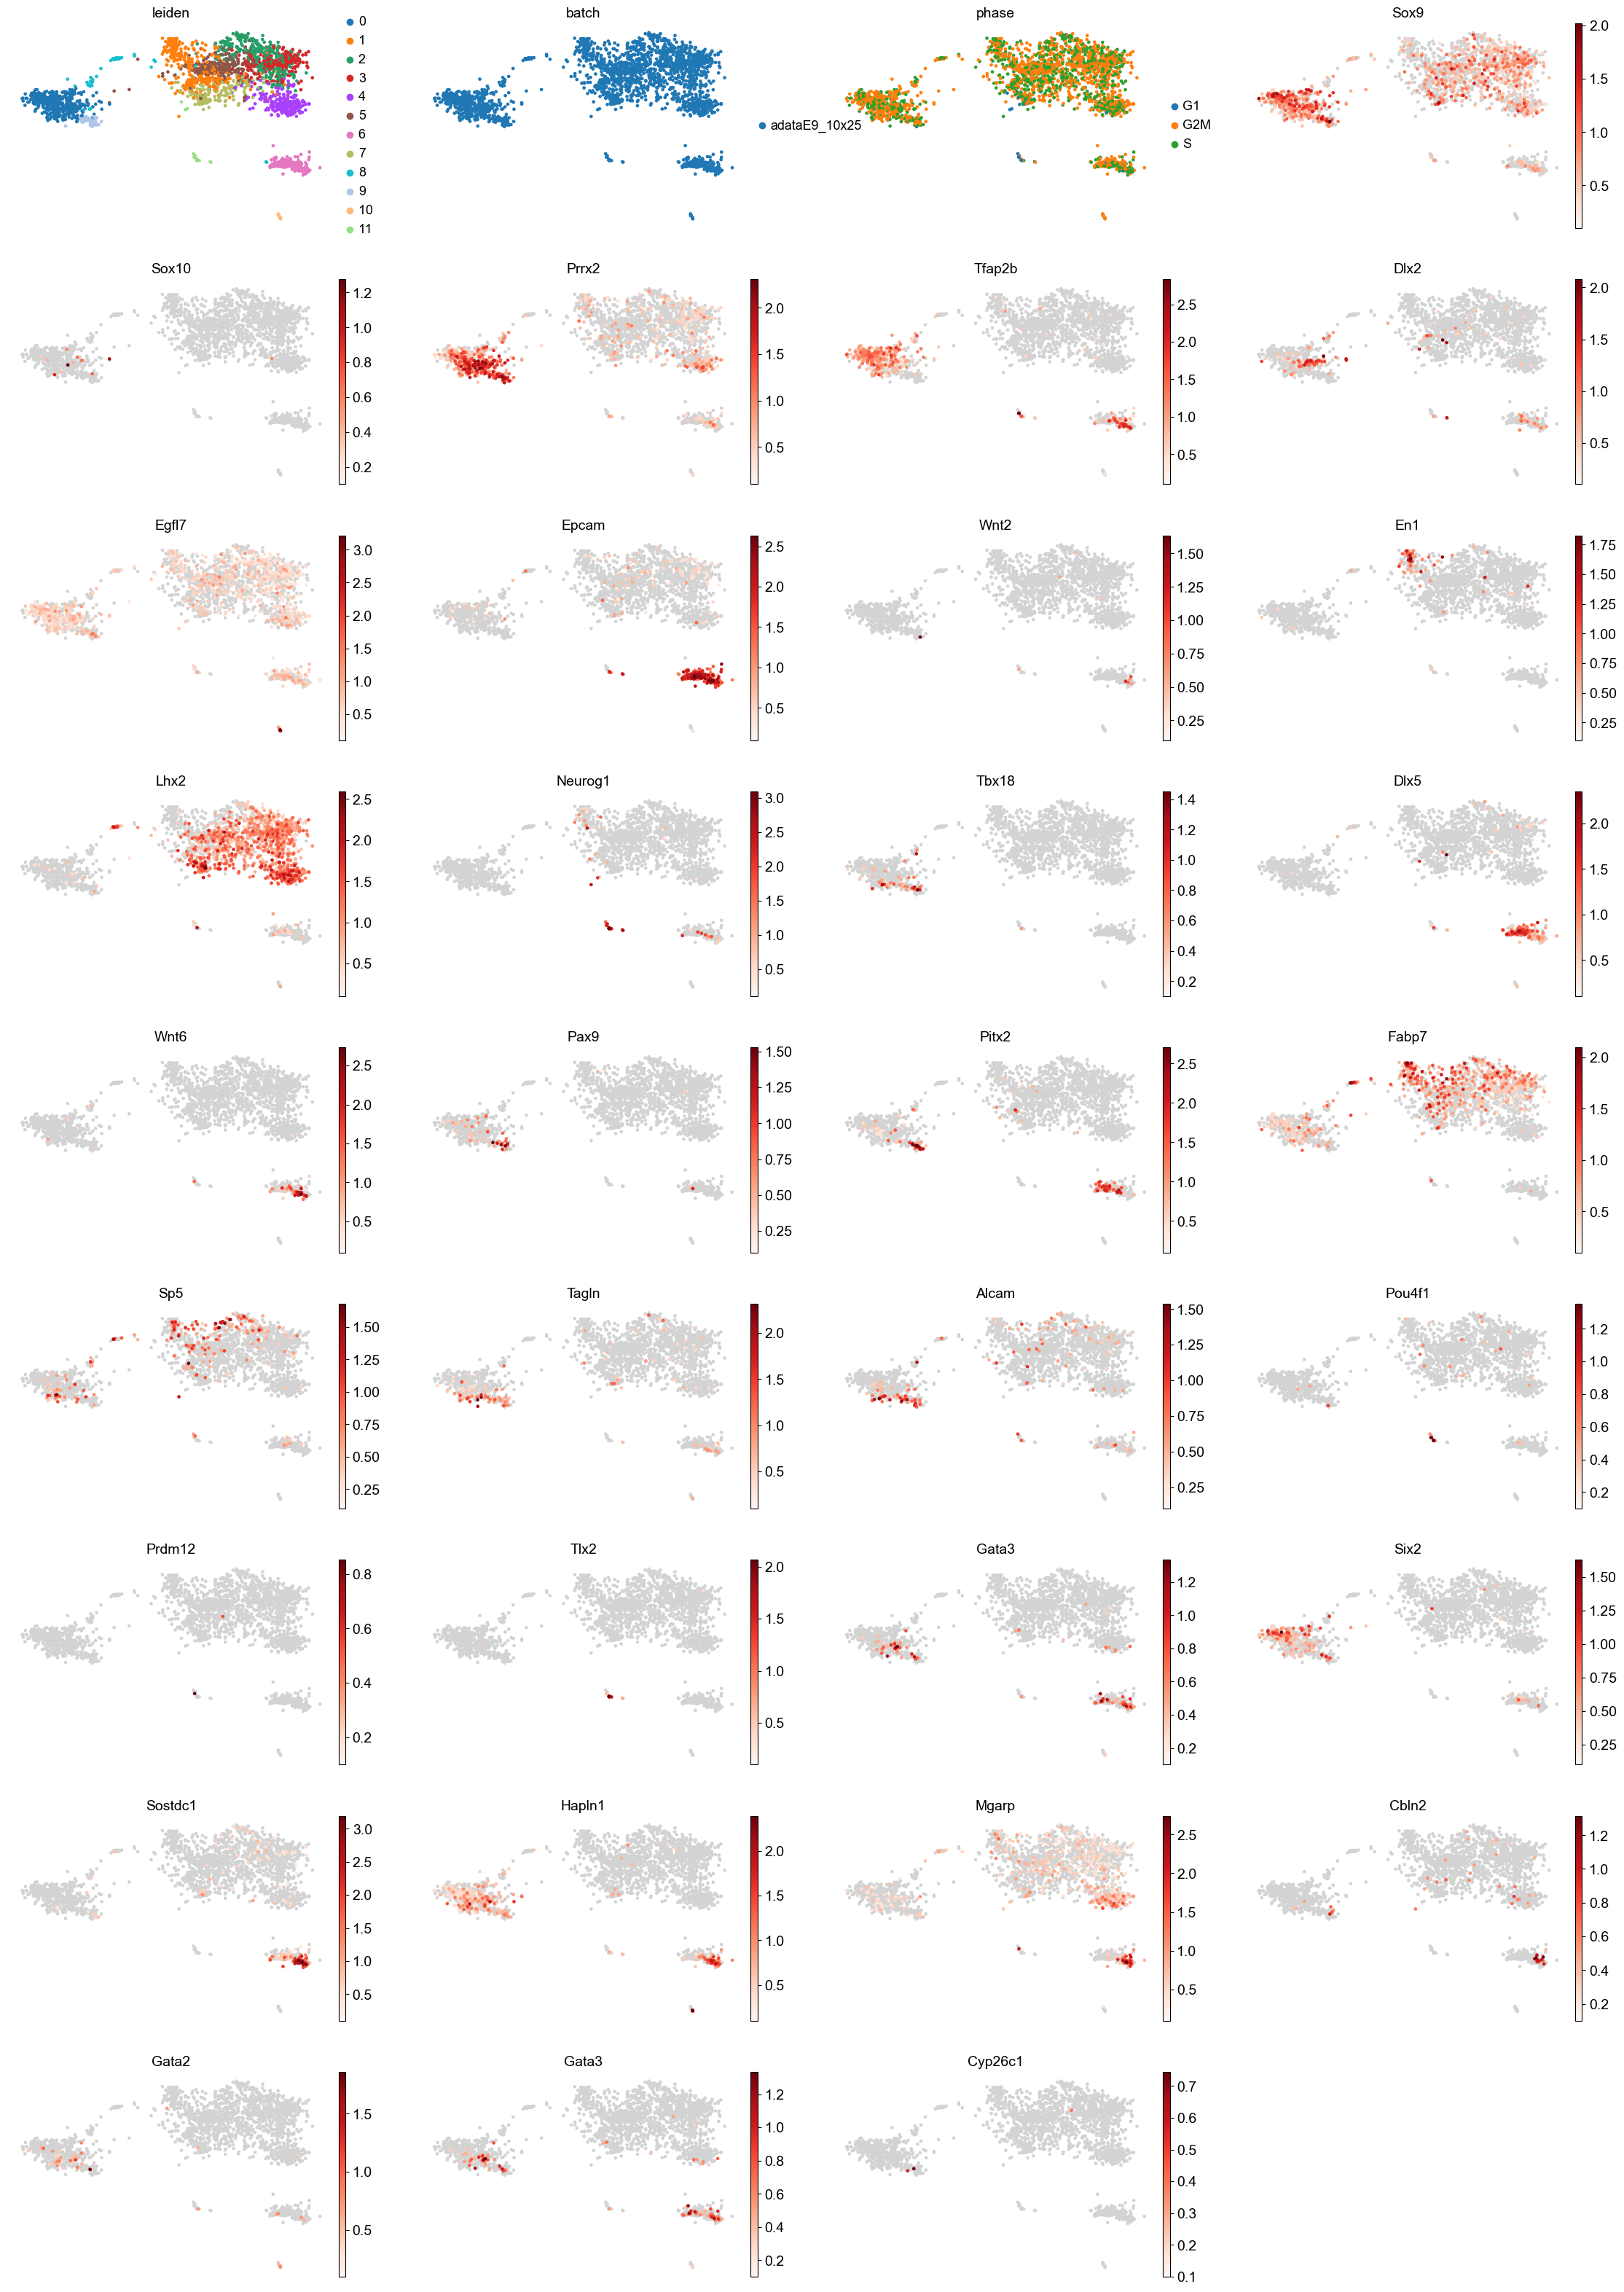

In [18]:
#keep cluster 0 for ectomesen
sc.pl.embedding(
    adata_E9,
    basis='X_scvi_MDE',
    color=['leiden','batch','phase','Sox9','Sox10','Prrx2','Tfap2b','Dlx2',
           'Egfl7', #Endothelial
           'Epcam', #ectoderm
           'Wnt2', #heart stuff
           'En1', #brain stuff
           'Lhx2', #prospective telencephalon
           'Neurog1',
           'Tbx18', #mesoderm
           'Dlx5', 'Wnt6', #placode
           'Pax9', #this stuff is def not ectomesen, I think ocular, Pitx2 + as well
           'Pitx2',
           'Fabp7',
           'Sp5',
           'Tagln',
           'Alcam',
           'Pou4f1',
           'Prdm12',
           'Tlx2',
           'Gata3',
           'Six2',
           'Sostdc1',
           'Hapln1',
           'Mgarp',
           'Cbln2',
           'Gata2',
           'Gata3',
           'Cyp26c1',
          ],
    #groups='17',
    frameon=False,
    ncols=4,
    cmap = reds,
    vmin=0.1,
)

In [5]:
adata_E9_mesen = adata_E9[adata_E9.obs['leiden'].isin(['0', #subset out mesenchyme cluster
                                                            #'6',
                                                           ])].copy()
adata_E9_mesen

AnnData object with n_obs × n_vars = 523 × 22912
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'sample', 'barcode', 'batch', 'doublet_score', 'predicted_doublets', 'predicted_doublets_based_on_10x_chromium_spec', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'pct_counts_unspliced', 'pred_doubl_cat', 'stage', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_name', 'ensembl_id', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'phase_colors', 'rank_genes_groups', 'wilcoxon'
    obsm: 'X_scvi', 'X_scvi_MDE', '_scvi_extra_continuous_covs'
    layers: 'ambiguous', 'matrix', 'original_counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

1709725737.4199274: Regressing cell cycle
1709725750.3551865: PCA
1709725750.5249994: Neighbors
1709725754.174515: MDE
1709725755.5161524: Leiden clustering


/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


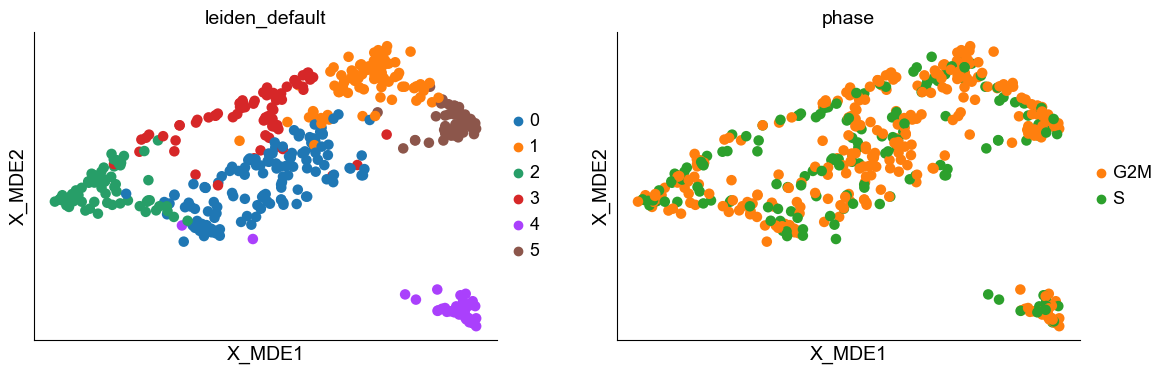

In [6]:
default_regress_cycle_to_mde(adata_E9_mesen, n_neighbors = 15,n_comps=10, skip_preprocess = False, resolution = 0.5)

In [7]:
#adata_E9_mesen = adata_E9_mesen[adata_E9_mesen.obs['leiden_default']!='2'].copy() #remove tagln zic1 cluster

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


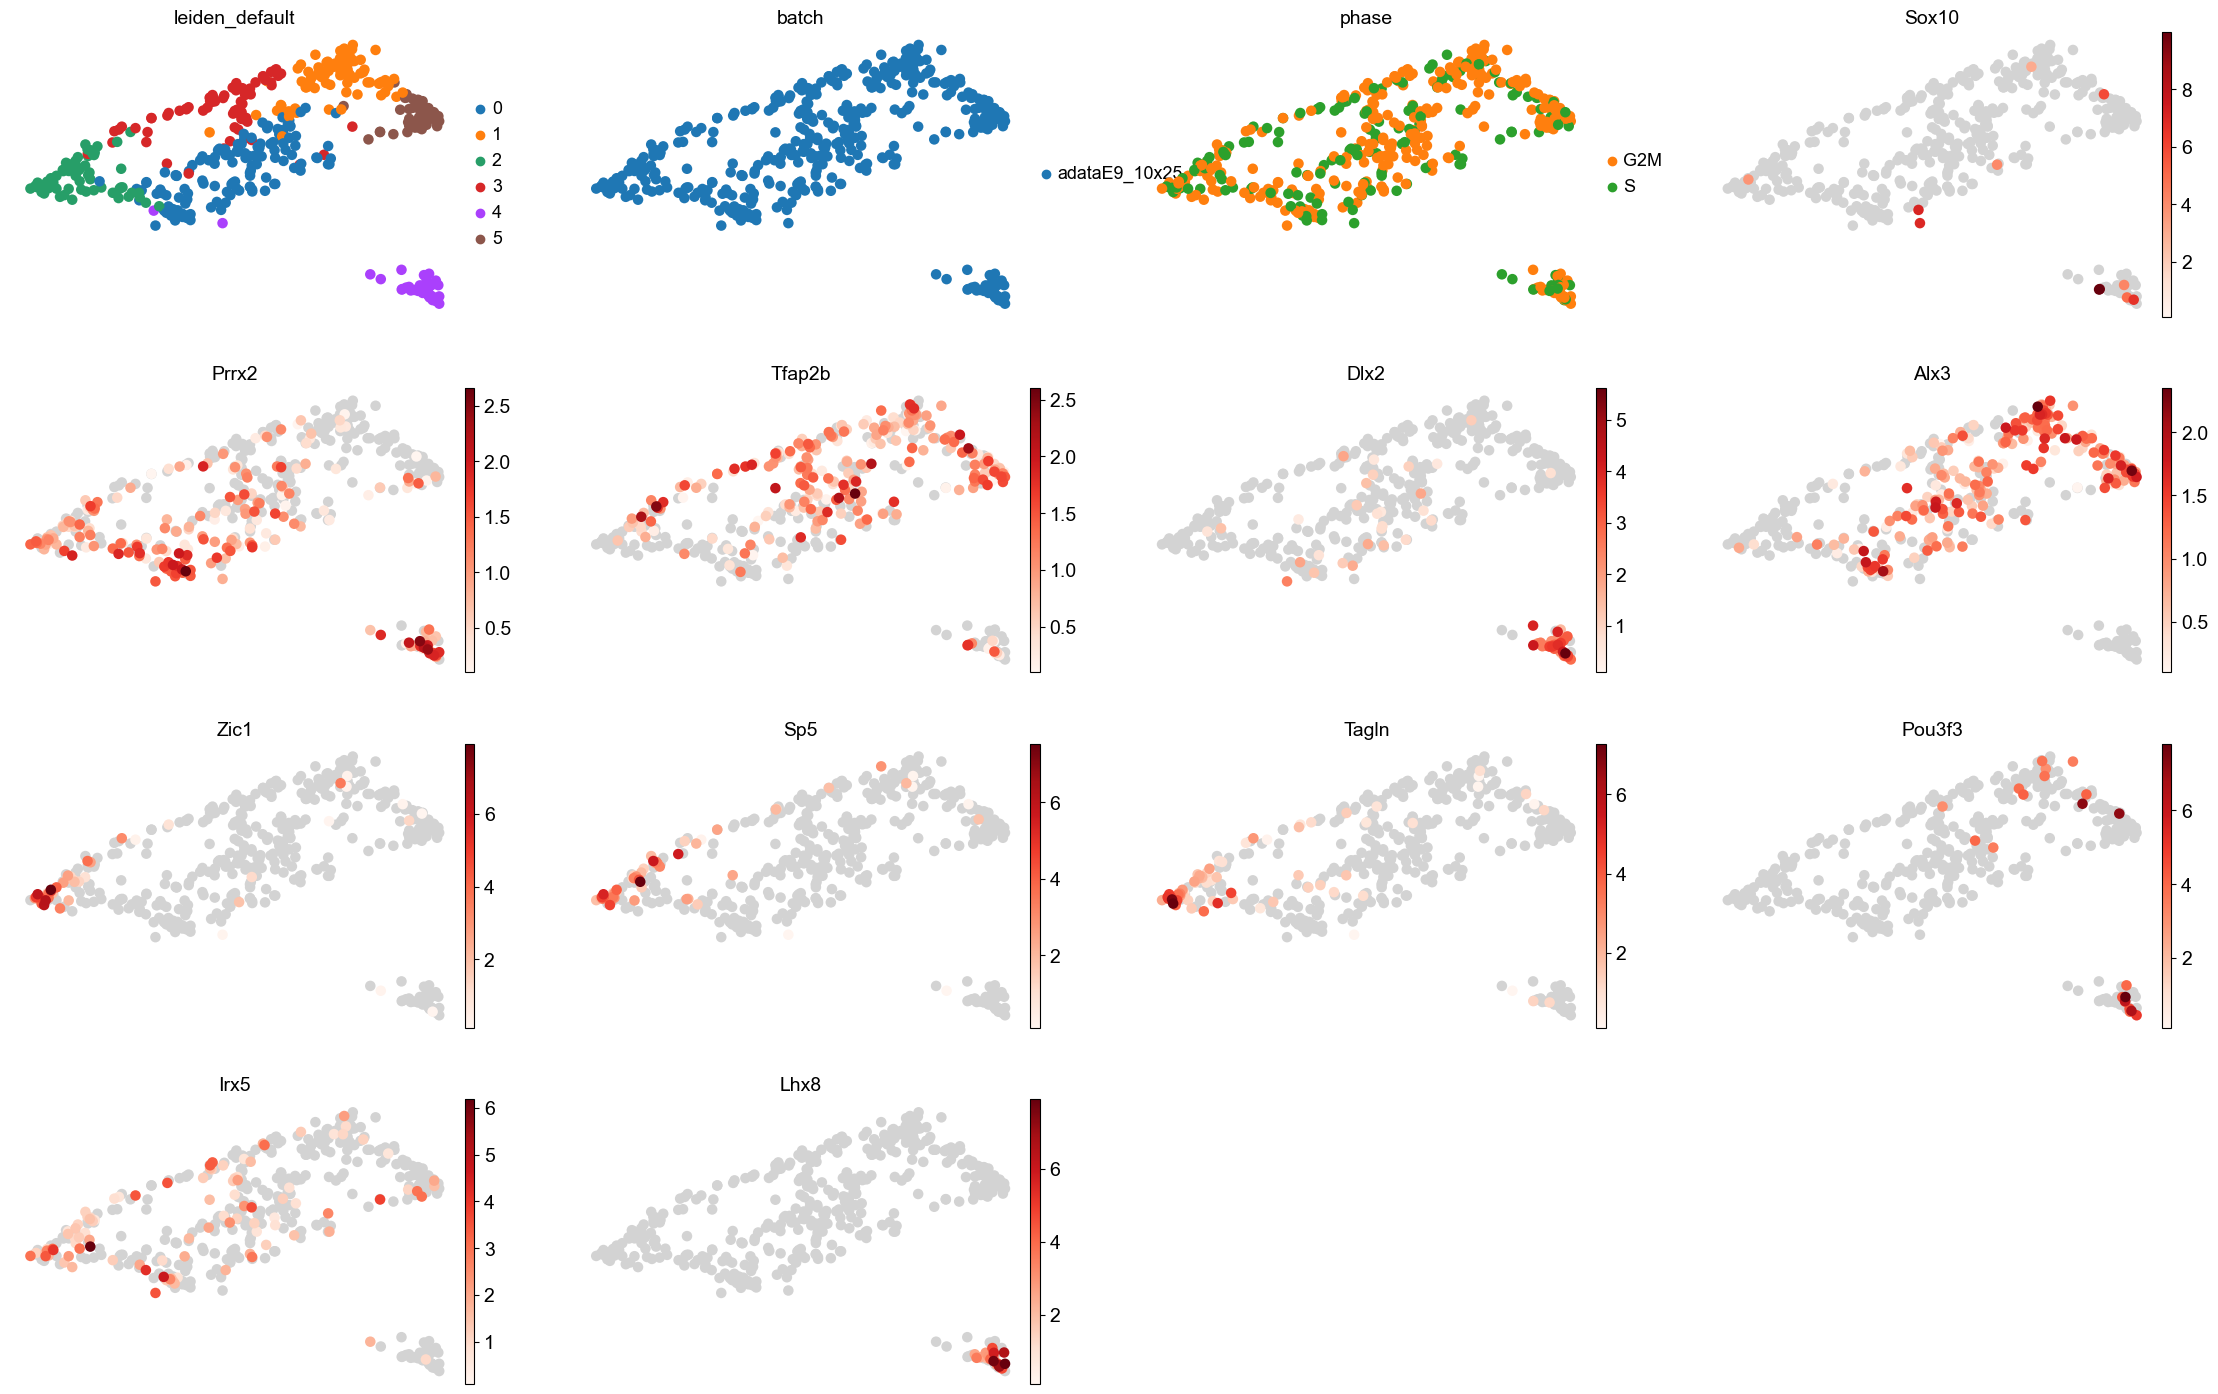

In [16]:
sc.pl.embedding(
    adata_E9_mesen,
    basis='X_MDE',
    color=['leiden_default','batch','phase','Sox10','Prrx2','Tfap2b','Dlx2','Alx3',
           'Zic1','Sp5','Tagln','Pou3f3','Irx5','Lhx8',
          ],
    #groups='17',
    frameon=False,
    ncols=4,
    cmap = reds,
    vmin=0.1,
)

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


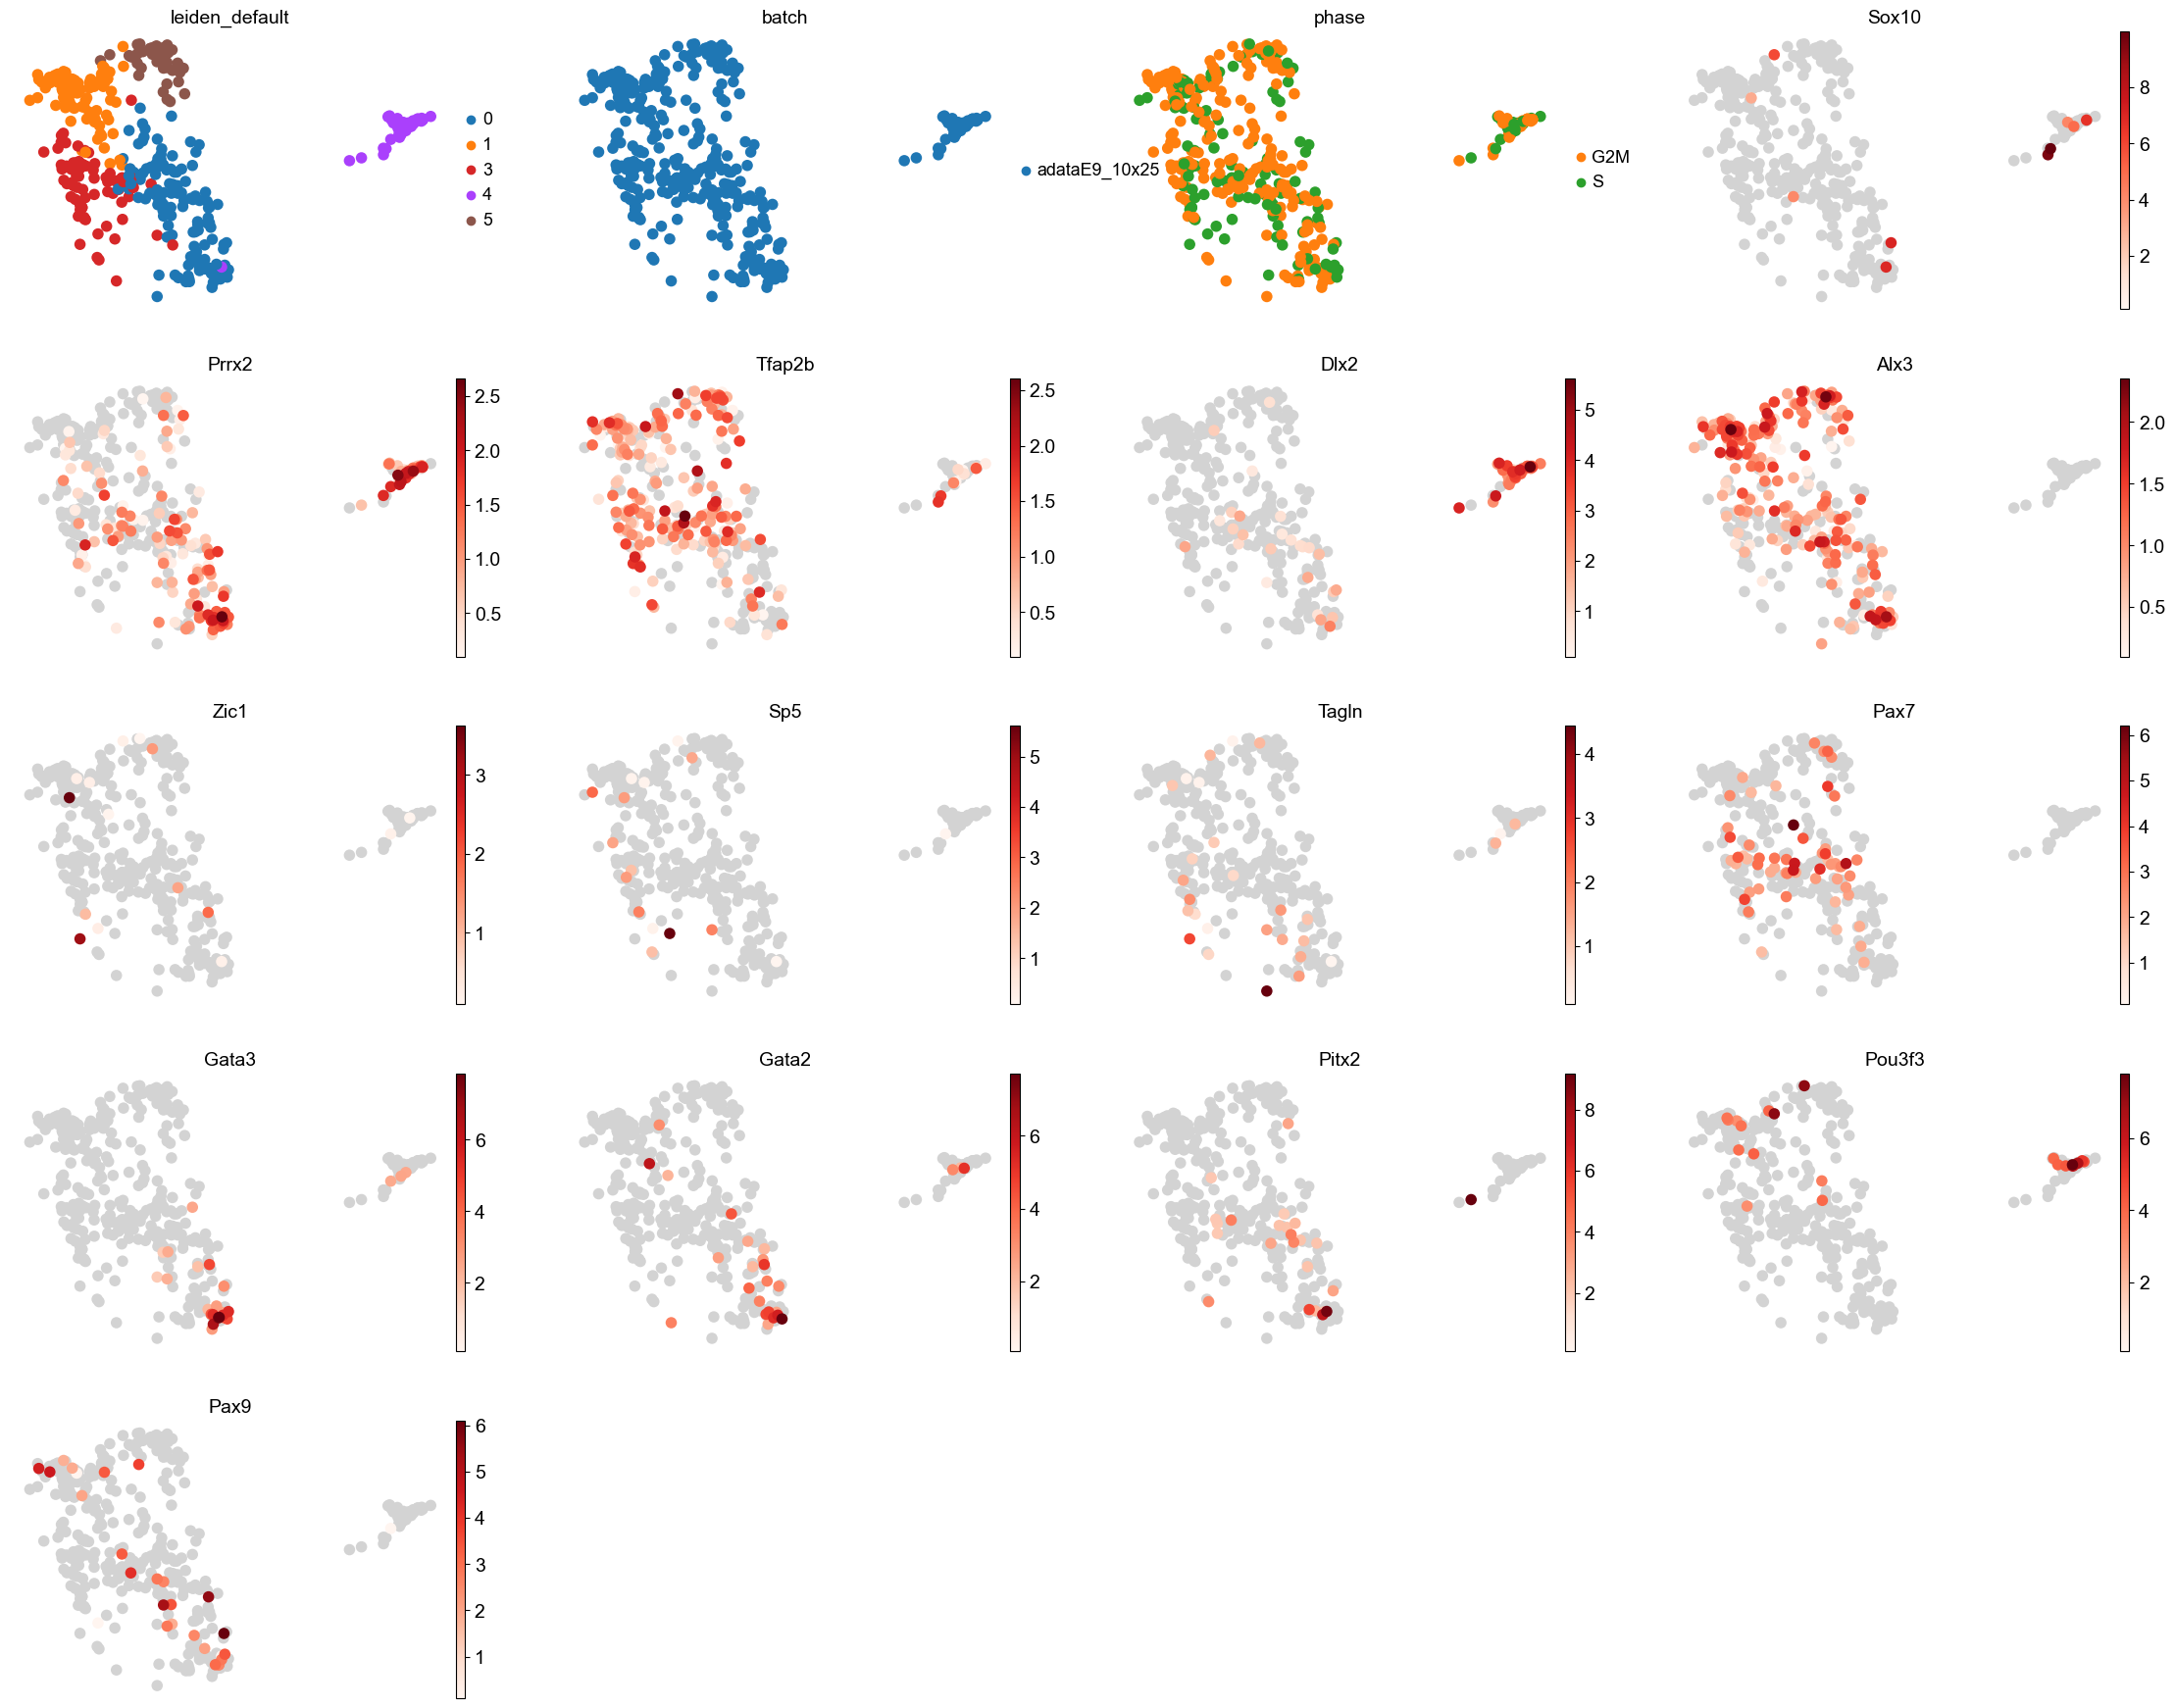

In [184]:
sc.pl.embedding(
    adata_E9_mesen,
    basis='X_MDE',
    color=['leiden_default','batch','phase','Sox10','Prrx2','Tfap2b','Dlx2','Alx3',
           'Zic1','Sp5','Tagln','Pax7','Gata3','Gata2','Pitx2','Pou3f3','Pax9',
          ],
    #groups='17',
    frameon=False,
    ncols=4,
    cmap = reds,
    vmin=0.1,
)

In [10]:
#renaming clusters
adata_E9_mesen.obs['E9_mesen_annotation_coarse'] = adata_E9_mesen.obs['leiden_default'] #create new column
adata_E9_mesen.obs['E9_mesen_annotation_coarse'] = adata_E9_mesen.obs['E9_mesen_annotation_coarse'].cat.add_categories(['Frontonasal Mesenchyme',
                                                                                                                        'Maxillary Mesenchyme',])#add category names

adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '0'].obs.index,'E9_mesen_annotation_coarse'] = 'Frontonasal Mesenchyme' #rename cluster 0
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '1'].obs.index,'E9_mesen_annotation_coarse'] = 'Frontonasal Mesenchyme'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '3'].obs.index,'E9_mesen_annotation_coarse'] = 'Frontonasal Mesenchyme'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '5'].obs.index,'E9_mesen_annotation_coarse'] = 'Frontonasal Mesenchyme'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '4'].obs.index,'E9_mesen_annotation_coarse'] = 'Maxillary Mesenchyme'
adata_E9_mesen.obs['E9_mesen_annotation_coarse'] = adata_E9_mesen.obs['E9_mesen_annotation_coarse'].cat.remove_unused_categories() #remove unused categories

In [11]:
#renaming clusters
adata_E9_mesen.obs['E9_mesen_annotation_fine'] = adata_E9_mesen.obs['leiden_default'] #create new column
adata_E9_mesen.obs['E9_mesen_annotation_fine'] = adata_E9_mesen.obs['E9_mesen_annotation_fine'].cat.add_categories(['Frontonasal Mesenchyme',
                                                                                                                        'Maxillary Mesenchyme',
                                                                                                                    'Prrx2+ Gata3+ ?',])#add category names

adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '0'].obs.index,'E9_mesen_annotation_fine'] = 'Prrx2+ Gata3+ ?' #rename cluster 0
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '1'].obs.index,'E9_mesen_annotation_fine'] = 'Frontonasal Mesenchyme' #tagln2?
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '3'].obs.index,'E9_mesen_annotation_fine'] = 'Frontonasal Mesenchyme'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '5'].obs.index,'E9_mesen_annotation_fine'] = 'Frontonasal Mesenchyme'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['leiden_default'] == '4'].obs.index,'E9_mesen_annotation_fine'] = 'Maxillary Mesenchyme'
adata_E9_mesen.obs['E9_mesen_annotation_fine'] = adata_E9_mesen.obs['E9_mesen_annotation_fine'].cat.remove_unused_categories() #remove unused categories

In [13]:
adata_E9_mesen.obs['integration_label'] = 'FnP'
adata_E9_mesen.obs.loc[adata_E9_mesen[adata_E9_mesen.obs['E9_mesen_annotation_coarse'] == 'Maxillary Mesenchyme'].obs.index,'integration_label'] = 'MxP' 
adata_E9_mesen.obs['integration_label'] = adata_E9_mesen.obs['integration_label'].astype('category')

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


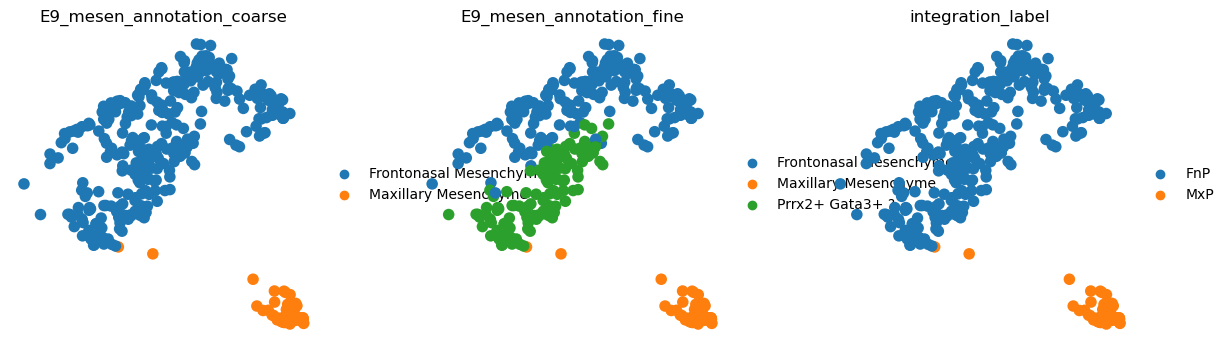

In [14]:
sc.pl.embedding(
    adata_E9_mesen,
    basis='X_MDE',
    color=['E9_mesen_annotation_coarse','E9_mesen_annotation_fine','integration_label',
          ],
    #groups='17',
    frameon=False,
    ncols=4,
    cmap = reds,
    vmin=0.1,
)

In [3]:
#adata_E9_mesen.write('anndata_objects/adata_E9_mesen_annotated.h5ad')
adata_E9_mesen = sc.read('anndata_objects/adata_E9_mesen_annotated.h5ad')

In [12]:
adata_E9_ecto = adata_E9[adata_E9.obs['leiden'].isin(['6',])].copy()


1709725844.6920245: Regressing cell cycle
1709725856.2678497: PCA
1709725856.3093503: Neighbors
1709725856.3180525: MDE
1709725856.762245: Leiden clustering


/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


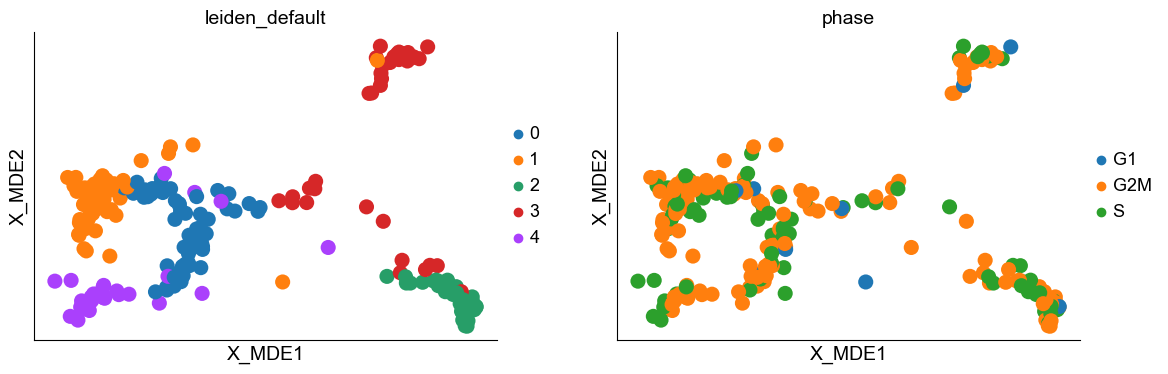

In [13]:
default_regress_cycle_to_mde(adata_E9_ecto, n_neighbors = 15,n_comps=8, skip_preprocess = False, resolution = 0.5)

In [ ]:
#sc.tl.umap(adata_E9_ecto)
sc.tl.leiden(adata_E9_ecto, resolution = .8, key_added = 'leiden_ecto')
sc.pl.embedding(adata_E9_ecto,
               # basis='X_harmony_MDE',
                basis='X_umap',
                color = ['leiden_default','leiden_ecto','batch','Krt23','Dlx5','Wnt6','Tfap2b','Sostdc1','Fn1','Pax6','Dlk1','Krt18','Hesx1','Pitx2','Socs2','Fgf8','Fgf17','Otx2','Hey1','Sox2','Dmrt3','Socs2',
                        'Aldh1a3','Six6','Vax2','Rax','Vsx2','Grhl3','Sfrp2','Sapcd1','Nav3','Lgr5','Fgf9','Six1','Gpr50','Lhx3','Pitx2',],
           ncols=3, cmap=reds, vmin=0.3)

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


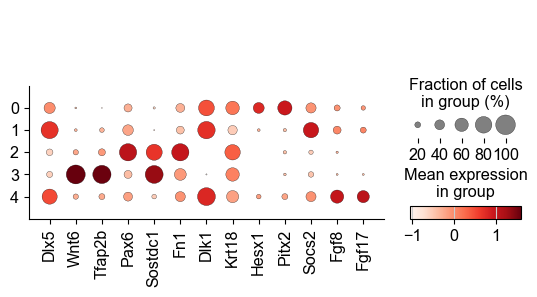

In [165]:
sc.pl.dotplot(adata_E9_ecto, var_names = ['Dlx5','Wnt6','Tfap2b','Pax6','Sostdc1','Fn1','Dlk1','Krt18','Hesx1','Pitx2','Socs2','Fgf8','Fgf17',], groupby = 'leiden_default')

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


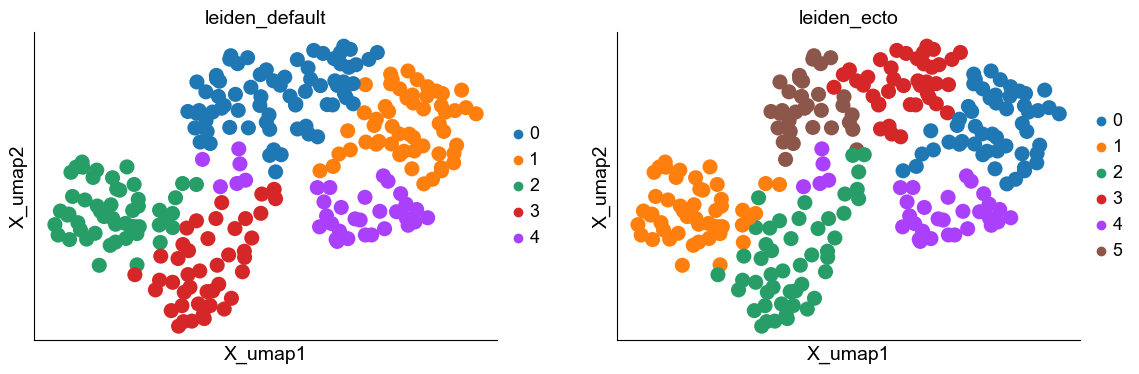

In [32]:
sc.pl.embedding(adata_E9_ecto,
               # basis='X_harmony_MDE',
                basis='X_umap',
                color = ['leiden_default','leiden_ecto'],
           ncols=3, cmap=reds, vmin=0.3)

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


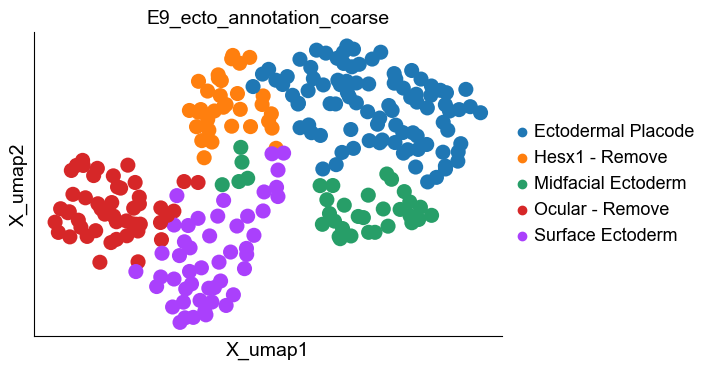

/home/jupyter-seton/micromamba/envs/cellrank/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


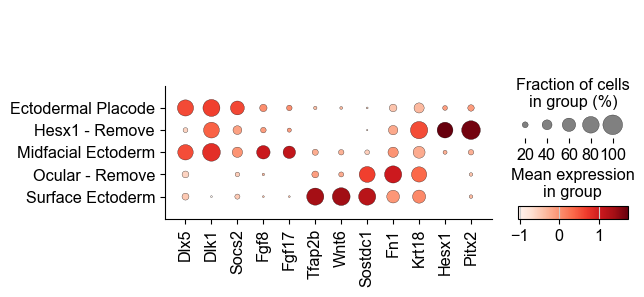

In [4]:
#renaming clusters coarse
adata_E9_ecto.obs['E9_ecto_annotation_coarse'] = 'tmp'

adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '5'].obs.index,'E9_ecto_annotation_coarse'] = 'Hesx1 - Remove' #Dlx5 Dlk1 Hesx1 Pitx2
adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '1'].obs.index,'E9_ecto_annotation_coarse'] = 'Ocular - Remove' #Pax6 Sostdc1 Fn1 Krt18 #eye placode, remove

adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '0'].obs.index,'E9_ecto_annotation_coarse'] = 'Ectodermal Placode' #Dlx5 Dlk1 Socs2
adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '3'].obs.index,'E9_ecto_annotation_coarse'] = 'Ectodermal Placode' #Dlx5 Dlk1 Socs2


adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '2'].obs.index,'E9_ecto_annotation_coarse'] = 'Surface Ectoderm' #Wnt6 Tfap2b Sostdc1

adata_E9_ecto.obs.loc[adata_E9_ecto[adata_E9_ecto.obs['leiden_ecto'] == '4'].obs.index,'E9_ecto_annotation_coarse'] = 'Midfacial Ectoderm' #Dlx5 Dlk1 Fgf8 Fgf17

adata_E9_ecto.obs['E9_ecto_annotation_coarse'] = adata_E9_ecto.obs['E9_ecto_annotation_coarse'].astype('category')
#remove Hesx1, Pitx2 cluster
#remove Pax6 Aldh1a3 Fn1 Cbln2
#keep rest

#surface ecto Wnt6
#Fgf8 midfacial ecto
#other cluster socs2 placode

adata_E9_ecto.obs['E9_ecto_annotation_coarse'] = adata_E9_ecto.obs['E9_ecto_annotation_coarse'].cat.remove_unused_categories() #remove unused categories

sc.pl.embedding(adata_E9_ecto,
               # basis='X_harmony_MDE',
                basis='X_umap',
                color = ['E9_ecto_annotation_coarse'],
           ncols=3, cmap=reds, vmin=0.3)

sc.pl.dotplot(adata_E9_ecto, var_names = ['Dlx5','Dlk1','Socs2','Fgf8','Fgf17','Tfap2b','Wnt6','Sostdc1','Fn1','Krt18','Hesx1','Pitx2',], 
              groupby = 'E9_ecto_annotation_coarse')

In [5]:
adata_E9_ecto.write('anndata_objects/adata_E9_ecto_annotated.h5ad')

In [ ]:
plot_deg_embedding(adata = adata_E9_ecto, 
                   groupby = 'leiden_ecto', 
                   cluster_name = '6', 
                   n_genes = 200, 
                   method = 'wilcoxon',
                   basis = 'X_umap')